Import libraries and data

In [107]:
import pandas as pd
import pysal
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection  import train_test_split 
import statsmodels.api as sm
from sklearn.preprocessing import Imputer
import pysal as ps
import copy as cp
from matplotlib import pylab as pl

In [198]:
crime_data = pd.read_csv('crime_data/man_cr_med.csv').set_index('lsoa')
all_data = pd.read_csv('data/manchester_data.csv').set_index('GEO_CODE').join(crime_data, how='left')

la_data = pd.read_csv('shapefiles/manlsoala.csv').set_index('geo_code')
lsoa_data = gpd.read_file('shapefiles/man_lsoa_all.shp').set_index('geo_code').join(la_data, how = 'left')

In [199]:
all_data.loc[all_data.vi_crime_count.isnull(), 'vi_crime_count'] = all_data['vi_crime_count'].median()

Preprocess data

In [197]:
all_data.head()

,age_mean,age_median,badhealth,centheat,nodepr,depr_4+,depr_3+,depr_2+,studenthhold,onefam_hhold,nocars,eth_hhi,ethwhite,vi_crime_count,crime_quar
GEO_CODE,,,,,,,,,,,,,,,
E01004766,42.10929,42.0,0.075377,0.937107,0.350943,0.002516,0.051572,0.298113,0.001258,0.510692,0.354717,0.176145,0.863693,31.0,Q3
E01004767,40.15316,39.0,0.048868,0.958333,0.446615,0.003906,0.046875,0.221354,0.010417,0.558594,0.244792,0.172369,0.796782,39.0,Q3
E01004768,39.94941,42.0,0.016864,0.991736,0.641322,0.000000,0.008264,0.084298,0.000000,0.796694,0.044628,0.221215,0.937539,7.0,Q1
E01004769,41.63690,42.5,0.035202,0.982482,0.554745,0.001460,0.016058,0.138686,0.000000,0.645255,0.132847,0.197436,0.930248,17.0,Q2
E01004770,44.31058,45.0,0.055290,0.978896,0.452922,0.001623,0.022727,0.194805,0.000000,0.733766,0.144481,0.136553,0.822526,13.0,Q1


In [303]:
# join df
spatial_data = lsoa_data.join(all_data, how = 'left')

In [304]:
# fill nan with 0, so that it can be mapped
spatial_data.loc[spatial_data.vi_crime_count.isnull(), 'vi_crime_count'] = 0

In [305]:
# do median split for violent crime count
spatial_data['crime_med'] = np.nan  # Create a new column and set values to NaN
spatial_data.loc[spatial_data.vi_crime_count >= spatial_data.vi_crime_count.median(), 'crime_med'] = 'Above Median'
spatial_data.loc[spatial_data.vi_crime_count < spatial_data.vi_crime_count.median(), 'crime_med'] = 'Below Median'

In [306]:
(q1, q2, q3) = spatial_data['vi_crime_count'].quantile([0.25,0.5,0.75])

spatial_data['crime_quar'] = 'Q4'
spatial_data.loc[spatial_data.vi_crime_count <= q3, 'crime_quar'] = 'Q3'
spatial_data.loc[spatial_data.vi_crime_count <= q2, 'crime_quar'] = 'Q2'
spatial_data.loc[spatial_data.vi_crime_count <= q1, 'crime_quar'] = 'Q1'

In [307]:
(t1, t2) = spatial_data['vi_crime_count'].quantile([0.33,0.67])

spatial_data['crime_thir'] = 'T3'
spatial_data.loc[spatial_data.vi_crime_count <= t2, 'crime_thir'] = 'T2'
spatial_data.loc[spatial_data.vi_crime_count <= t1, 'crime_thir'] = 'T1'

In [308]:
spatial_data['crime_T1'] = 'Yes'
spatial_data.loc[spatial_data.crime_thir != 'T1', 'crime_T1'] = 'No'

In [37]:
'''
# using Mercator projection
fig, ax = plt.subplots(1, figsize=(15, 15))

spatial_data.to_crs({'init': 'epsg:3395'})\
            .plot(ax=ax,
                  column='vi_crime_count', 
                  #scheme='quantiles',
                  cmap='coolwarm', 
                  legend=True
                 #linewidth=0.00001
                 )\
            .set_title("Count of 'Violence and Sexual Offence' Crimes across Manchester LSOAs")

#ax.axis('off')#.legend(title='Crime Count')
#fig.colorbar(sm)
'''

'\n# using Mercator projection\nfig, ax = plt.subplots(1, figsize=(15, 15))\n\nspatial_data.to_crs({\'init\': \'epsg:3395\'})            .plot(ax=ax,\n                  column=\'vi_crime_count\', \n                  #scheme=\'quantiles\',\n                  cmap=\'coolwarm\', \n                  legend=True\n                 #linewidth=0.00001\n                 )            .set_title("Count of \'Violence and Sexual Offence\' Crimes across Manchester LSOAs")\n\n#ax.axis(\'off\')#.legend(title=\'Crime Count\')\n#fig.colorbar(sm)\n'

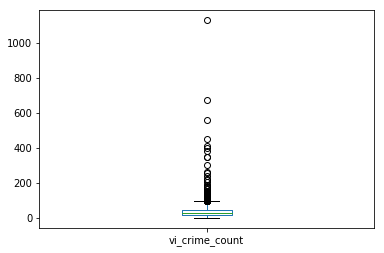

In [205]:
spatial_data['vi_crime_count'].plot(kind='box')

In [309]:
spatial_data.loc[spatial_data.vi_crime_count > 150, 'vi_crime_count'] = 150

Text(0.5, 1.0, "Thirds Split of 'Violence and Sexual Offence' Crime Count across Manchester LSOAs")

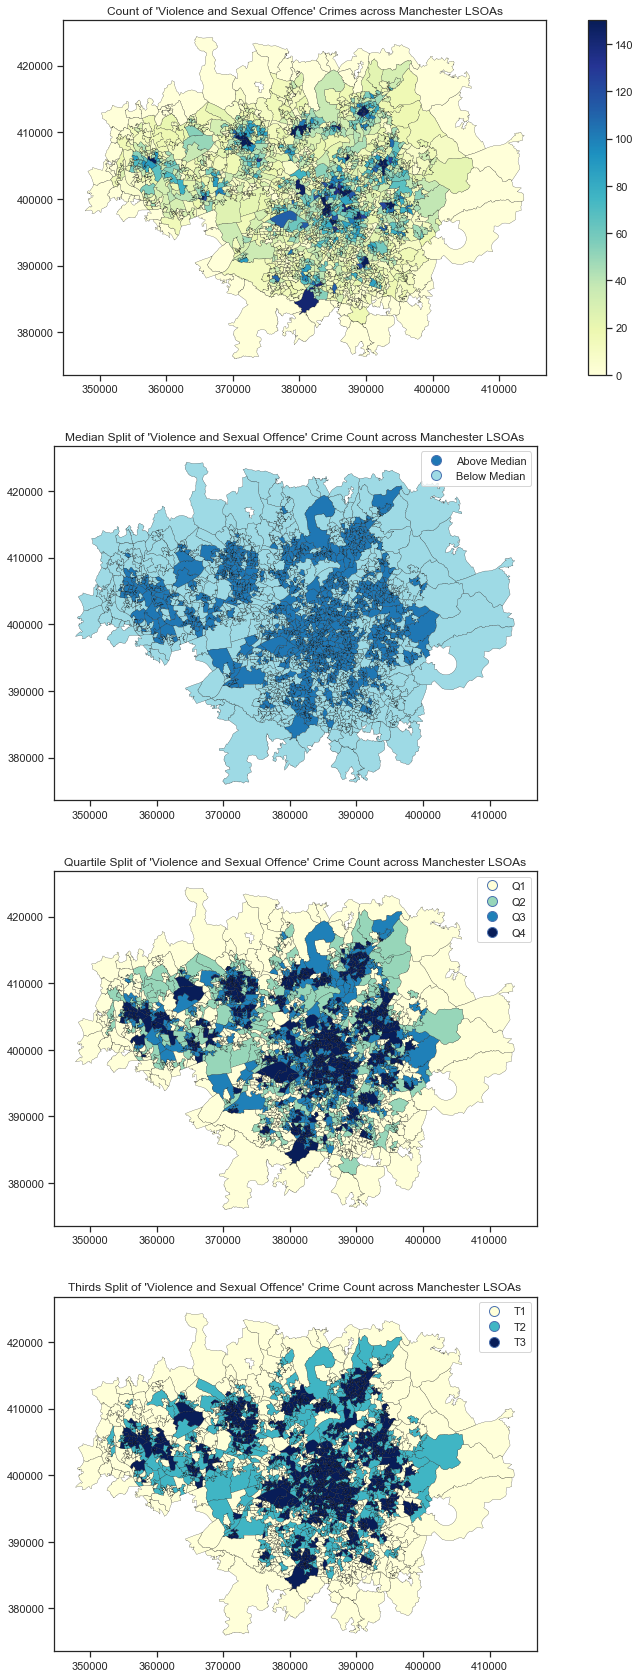

In [310]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(15, 30))

# Count map
spatial_data.plot(ax=ax1,
                  column='vi_crime_count', 
                  cmap='YlGnBu',
                  linewidth=0.2, edgecolor='black',
                  legend=True
                 )\
            .set_title("Count of 'Violence and Sexual Offence' Crimes across Manchester LSOAs")

#img = ax1.imshow(spatial_data, interpolation='nearest', vmin=0.5, vmax=0.99)
#fig.colorbar(img)
#fig.colorbar(sm)

# Median split map
spatial_data.plot(ax=ax2,
                  column='crime_med', 
                  cmap='tab20',
                  linewidth=0.2, edgecolor='black', 
                  legend=True
                 )\
            .set_title("Median Split of 'Violence and Sexual Offence' Crime Count across Manchester LSOAs")

# Quartile split map
spatial_data.plot(ax=ax3,
                  column='crime_quar', 
                  cmap='YlGnBu',
                  linewidth=0.2, edgecolor='black', 
                  legend=True
                 )\
            .set_title("Quartile Split of 'Violence and Sexual Offence' Crime Count across Manchester LSOAs")

# Thirds split map
spatial_data.plot(ax=ax4,
                  column='crime_thir', 
                  cmap='YlGnBu',
                  linewidth=0.2, edgecolor='black', 
                  legend=True
                 )\
            .set_title("Thirds Split of 'Violence and Sexual Offence' Crime Count across Manchester LSOAs")

In [194]:
'''
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5.5, 15))

# Count map
spatial_data[(spatial_data.la == "Manchester")].plot(ax=ax1,
                  column='vi_crime_count', 
                  cmap='YlGnBu',
                  linewidth=0.2, edgecolor='black',
                  legend=True
                 )\
            .set_title("Count of 'Violence and Sexual Offence' Crimes across Manchester LSOAs")

# Median split map
spatial_data[(spatial_data.la == "Manchester")].plot(ax=ax2,
                  column='crime_med', 
                  cmap='tab20',
                  linewidth=0.2, edgecolor='black', 
                  legend=True
                 )\
            .set_title("Median Split of 'Violence and Sexual Offence' Crime Count across Manchester LSOAs")
'''

'\nfig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5.5, 15))\n\n# Count map\nspatial_data[(spatial_data.la == "Manchester")].plot(ax=ax1,\n                  column=\'vi_crime_count\', \n                  cmap=\'YlGnBu\',\n                  linewidth=0.2, edgecolor=\'black\',\n                  legend=True\n                 )            .set_title("Count of \'Violence and Sexual Offence\' Crimes across Manchester LSOAs")\n\n# Median split map\nspatial_data[(spatial_data.la == "Manchester")].plot(ax=ax2,\n                  column=\'crime_med\', \n                  cmap=\'tab20\',\n                  linewidth=0.2, edgecolor=\'black\', \n                  legend=True\n                 )            .set_title("Median Split of \'Violence and Sexual Offence\' Crime Count across Manchester LSOAs")\n'

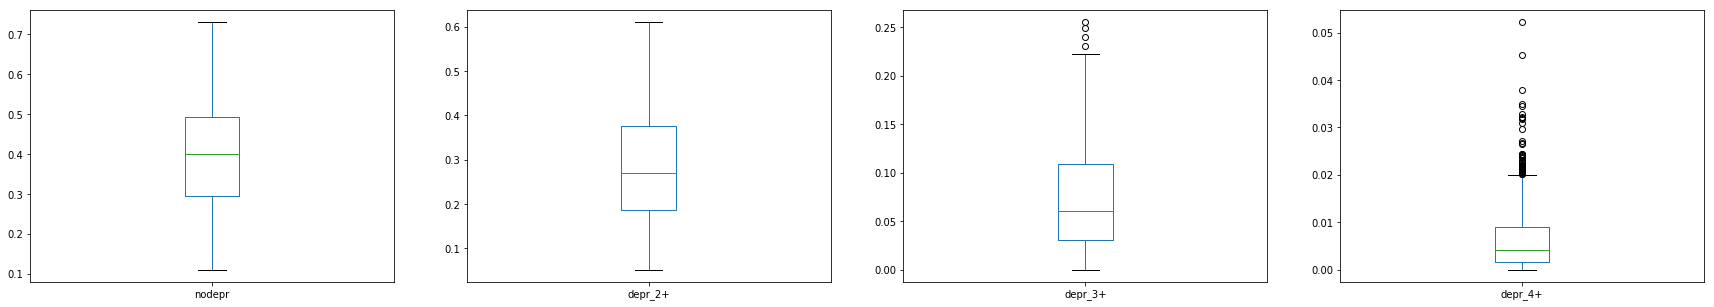

In [227]:
all_data[['nodepr', 'depr_2+', 'depr_3+', 'depr_4+']].plot(kind='box', subplots=True, figsize=(30, 5))
plt.show()

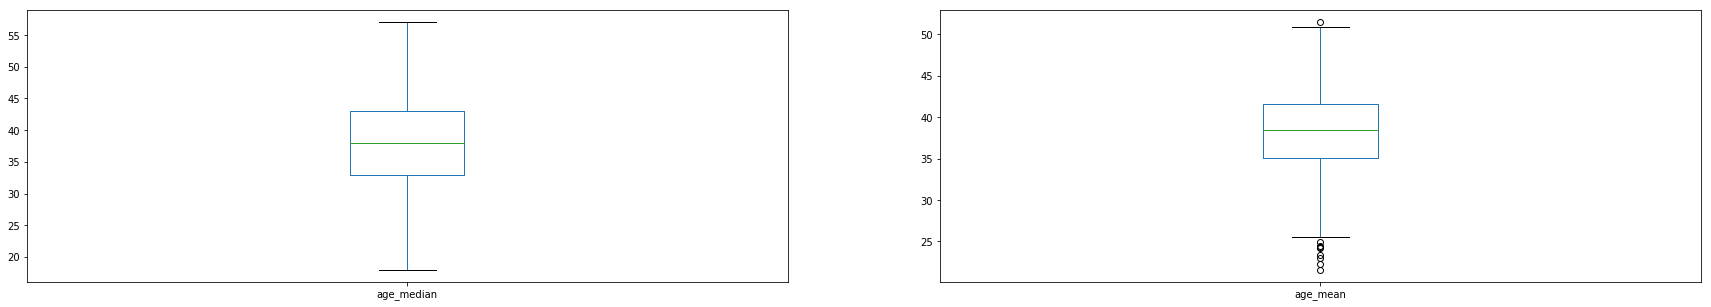

In [228]:
all_data[['age_median', 'age_mean']].plot(kind='box', subplots=True, figsize=(30, 5))
plt.show()

In [312]:
tokeep = ['crime_T1', 'age_median', 'badhealth', 'studenthhold', 'onefam_hhold', 'eth_hhi', 'depr_3+', 'nocars', ]

man_data = spatial_data[tokeep].dropna(axis = 0)

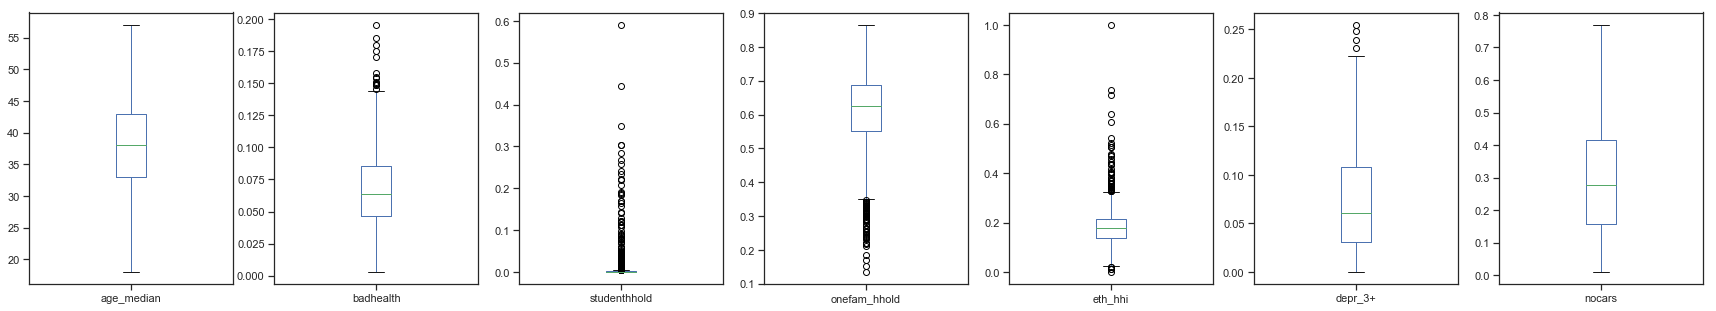

In [313]:
# box plots
man_data.plot(kind='box', subplots=True, figsize=(30, 5))
plt.show()

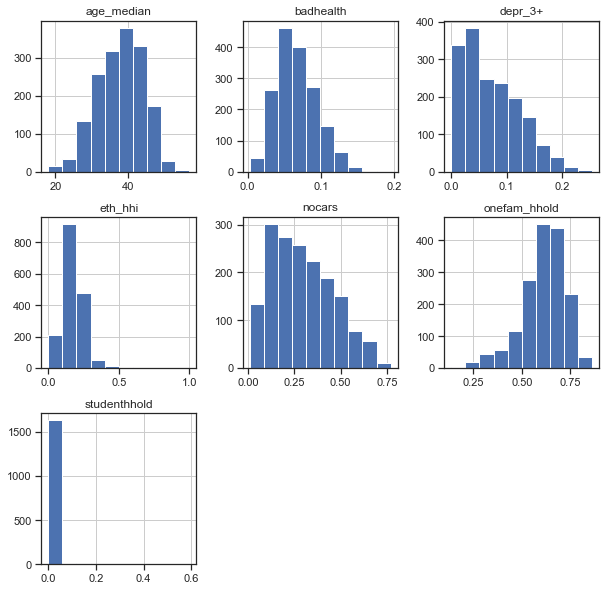

In [270]:
man_data.hist(figsize=(10, 10))
plt.show()

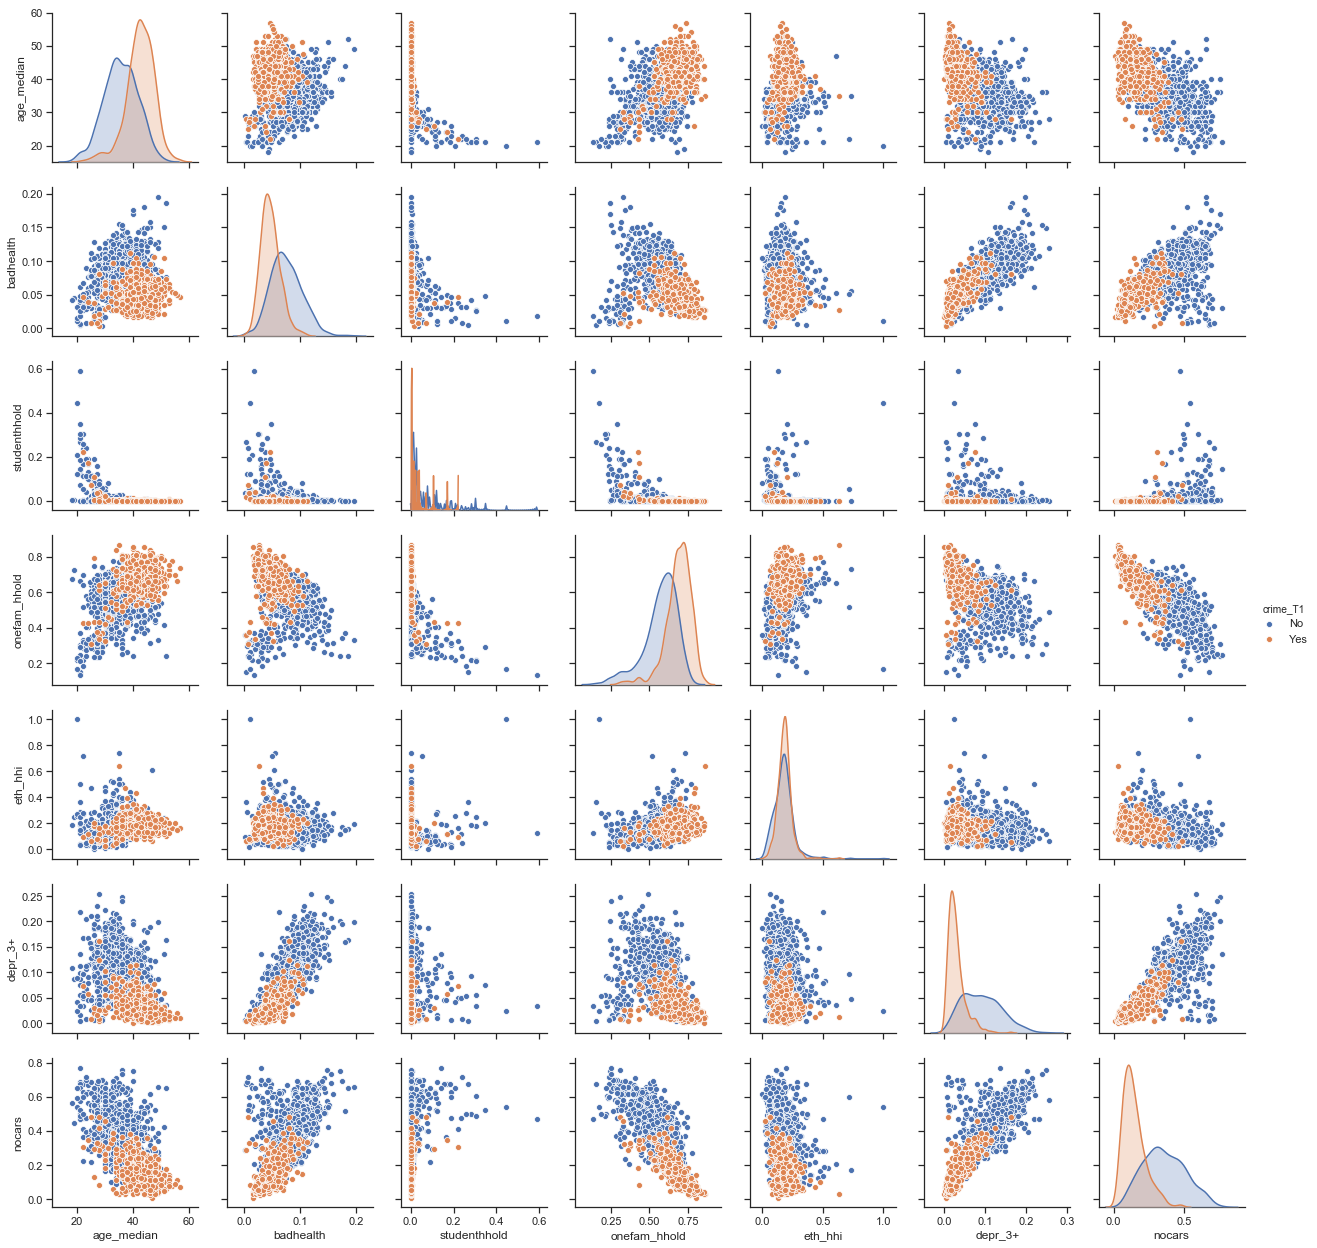

In [314]:
sns.set(style="ticks")
sns.pairplot(man_data, hue = 'crime_T1')

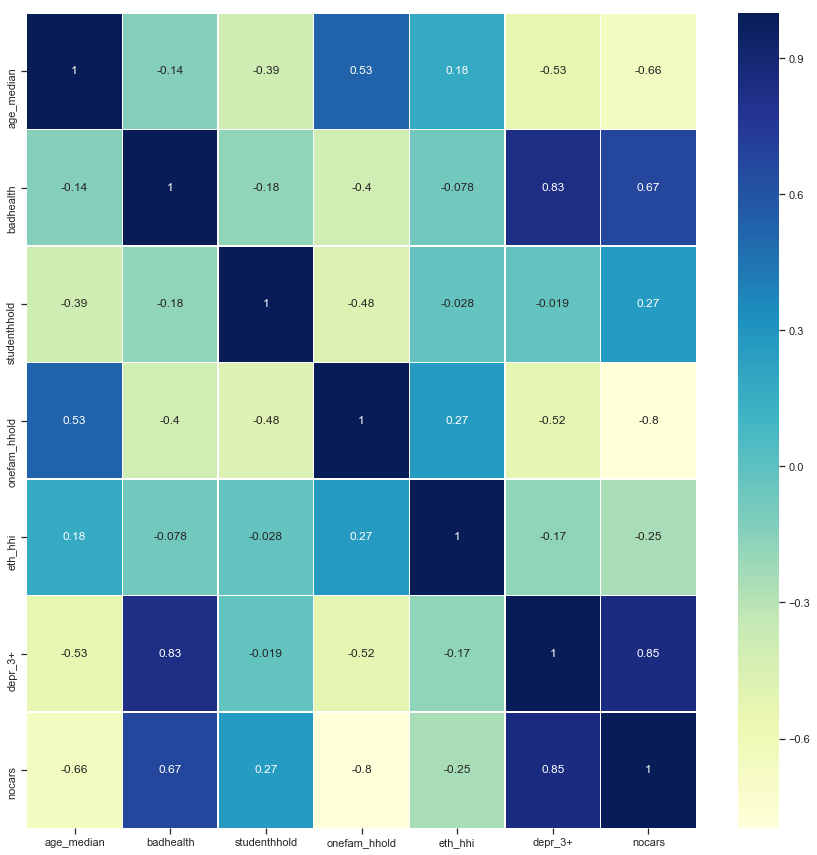

In [315]:
axsns = plt.subplots(figsize=(15, 15))
sns.heatmap(man_data.corr(), annot=True, linewidths=.5, cmap="YlGnBu")
plt.show()

# K-means

In [252]:
# use the elbow method to establish number of clusters
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(results)
    wcss.append(kmeans.inertia_)

In [253]:
"""
    K-Means parameters 
    n_clusters = the number of clusters
    init = the method for placing initial centroids
    max_iter = the maximum amount of iterations
    n_init = the number of times that K-means is run with different random centroids
    random_state = the seed value
"""
# use the elbow method
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter=300, n_init=10, random_state=1234)
    kmeans.fit(results)
    wcss.append(kmeans.inertia_)

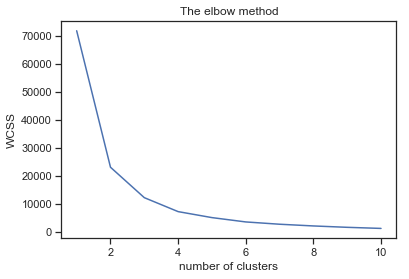

In [254]:
# Plot the WCSS results
plt.plot(range(1,11), wcss)
plt.title('The elbow method')
plt.xlabel('number of clusters')
plt.ylabel('WCSS')
plt.show()

In [255]:
# Apply K-means to petal data based on WCSS results
kmeans = KMeans(n_clusters=3, init = 'k-means++', max_iter=300, n_init=10, random_state=1234)

# this will create an arry for the predicted clusters for the petal data
y_kmeans = kmeans.fit_predict(results)

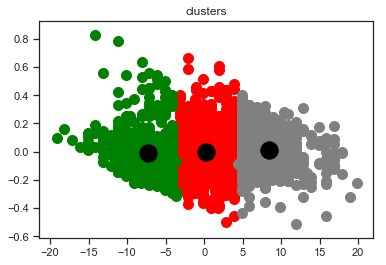

In [257]:
# Visualise the clusters
# Specify that we want the observation in X where the cluster == 0

"""
    X               = The dataset 
    [y_kmeans==0    = Where the cluster == 0 - uses the index of y-kmeans to selected rows from x
    , 0]            = The first column in the dataset
    s = 100         = The size of the points
    c = 'red'       = The color of the cluster
"""
plt.scatter(results[y_kmeans==0, 0], results[y_kmeans==0, 1], s=100, c='red')
plt.scatter(results[y_kmeans==1, 0], results[y_kmeans==1, 1], s=100, c='grey')
plt.scatter(results[y_kmeans==2, 0], results[y_kmeans==2, 1], s=100, c='green')
#plt.scatter(results[y_kmeans==3, 0], results[y_kmeans==3, 1], s=100, c='yellow')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=300, c='black')
plt.title('clusters')
plt.show()

# PCA

In [316]:
# Convert data to array
data = man_data.iloc[:,1:]#.values

In [317]:
# Perform PCA
pca = PCA(n_components=None) # Create an instance of the PCA class
"""
    We dont specify the amount of components to reduce to yet 
    as we want to see how many Princible Components explain the most varience in 
    the dataset
"""
pcaResults = pca.fit_transform(data) # Fit the data to the model
explained_variance = pca.explained_variance_ratio_ # Extract the varience

In [318]:
print(np.around(explained_variance,3) )

[0.999 0.001 0.    0.    0.    0.    0.   ]


In [319]:
# Convert data to array
# Perform PCA
pca = PCA(n_components=2) # Now specify 2 components
results = pca.fit_transform(data)

In [285]:
# won't include non-coloured veriosn

'''
# Show Plot
plt.scatter(results[:,0], results[:,1])
plt.title('PCA Analysis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
'''

"\n# Show Plot\nplt.scatter(results[:,0], results[:,1])\nplt.title('PCA Analysis')\nplt.xlabel('PC1')\nplt.ylabel('PC2')\nplt.show()\n"

In [321]:
colour_map = {
    'Yes': 'blue',
    'No' : 'orange',
    #np.nan : 'green'
}

In [299]:
colour_map = {
    'T1': 'green',
    'T2' : 'blue',
    'T3' : 'orange'
}

In [322]:
# Create an array of colours based on the target column
colours = [colour_map[c] for c in man_data['crime_T1']]

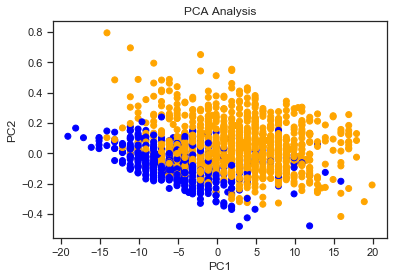

In [323]:
# Show Plot
plt.scatter(results[:,0], results[:,1], c=colours)
plt.title('PCA Analysis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Regression

In [324]:
man_data.head()

,crime_T1,age_median,badhealth,studenthhold,onefam_hhold,eth_hhi,depr_3+,nocars
geo_code,,,,,,,,
E01004962,No,34.0,0.036527,0.001412,0.653955,0.244471,0.040960,0.200565
E01005025,No,42.0,0.056414,0.001460,0.594161,0.157119,0.043796,0.251095
E01005865,No,46.0,0.038749,0.000000,0.643987,0.128445,0.015823,0.139241
E01006232,Yes,41.0,0.057143,0.000000,0.704336,0.336020,0.024967,0.052562
E01005501,No,43.0,0.145501,0.000000,0.382287,0.204973,0.154709,0.539238


In [273]:
#Reference Variable
man_data['_intercept'] = 1 # if all variables == 0

In [274]:
# Create Dummy Variables
dummy_df = pd.get_dummies(man_data.crime_thir, prefix='crime_thir')
man_data = man_data.join(dummy_df)
man_data = man_data.drop(['crime_thir', 'crime_thir_T2', 'crime_thir_T3'], axis=1)

# View Results
man_data.head()

,age_median,badhealth,studenthhold,onefam_hhold,eth_hhi,depr_3+,nocars,_intercept,crime_thir_T1
geo_code,,,,,,,,,
E01004962,34.0,0.036527,0.001412,0.653955,0.244471,0.040960,0.200565,1,0
E01005025,42.0,0.056414,0.001460,0.594161,0.157119,0.043796,0.251095,1,0
E01005865,46.0,0.038749,0.000000,0.643987,0.128445,0.015823,0.139241,1,0
E01006232,41.0,0.057143,0.000000,0.704336,0.336020,0.024967,0.052562,1,1
E01005501,43.0,0.145501,0.000000,0.382287,0.204973,0.154709,0.539238,1,0


In [275]:
# import the dataset
x = man_data.iloc[:, :-1] # predictors
y = man_data.iloc[:,-1] # result 

# split the dataset into the training set and test set
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.2, random_state=5)

In [276]:
# Make the model
logit = sm.Logit(y_train, x_train)

# Fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: inf
         Iterations 8


C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\statsmodels\discrete\discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [277]:
# View the results
print (result.summary())

                           Logit Regression Results                           
Dep. Variable:          crime_thir_T1   No. Observations:                 1338
Model:                          Logit   Df Residuals:                     1330
Method:                           MLE   Df Model:                            7
Date:                Fri, 01 Mar 2019   Pseudo R-squ.:                     inf
Time:                        15:50:32   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
                                        LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
age_median       0.0549      0.024      2.317      0.020       0.008       0.101
badhealth       -1.8014      8.272     -0.218      0.828     -18.015      14.412
studenthhold     4.7618      3.366      1.41

C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [278]:
# Get the predicted values from the test set
y_pred = result.predict(x_test)

In [279]:
# print confusion matrix
from sklearn.metrics import *
print(confusion_matrix(y_test, np.round(y_pred,0)))

[[207  33]
 [ 23  72]]


In [280]:
# Accuracy %
from sklearn.metrics import *
accuracy_score(y_test, np.round(y_pred,0))

0.8328358208955224